In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

[nltk_data] Downloading package punkt to /Users/yunxiao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunxiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)




In [3]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)


In [6]:
#disc=df['newComments'].values.tolist()
#vect.fit(disc)
#columns_name=vect.get_feature_names()
#disc_vec=vect.fit_transform(disc)

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
#disc_vec_tfidf = tfidf_transformer.fit_transform(disc_vec)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']

X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.3)
X_train_onehot = vect.fit_transform(X_train_kera)
X_train_onehot = tfidf_transformer.fit_transform(X_train_onehot)
X_test_onehot = vect.transform(X_test_kera)
X_test_onehot = tfidf_transformer.fit_transform(X_test_onehot)


In [9]:
#X_test_kera[0:,0].shape,y_test_kera.shape,X_train_kera.shape

In [10]:
from sklearn.linear_model import LinearRegression
cls = LinearRegression()
cls.fit(X_train_onehot,y_train_kera)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [11]:
y_pred=cls.predict(X_test_onehot)

In [12]:
y_pred.shape,X_train_onehot.shape,y_test_kera.shape

((10399,), (24262, 2363), (10399,))

In [13]:
from sklearn.metrics import mean_squared_error,r2_score
mean_squared_error(y_test_kera,y_pred)

0.04637301858407448

In [14]:
#from scipy.sparse import csr_matrix
#X_train_onehot = csr_matrix((X_train_onehot.data, X_train_onehot.indices, X_train_onehot.indptr), shape=(10399,1))
#y_test_kera = csr_matrix((y_test_kera.data, y_test_kera.indices, y_test_kera.indptr), shape=(10399,1))

In [15]:
a = []
for i in X_train_onehot:
    a.append(i)
    

Coefficients: 
 [ 0.08815505  0.06671961 -0.02771273 ...  0.14351516  0.47669488
  0.25938108]
Mean squared error: 0.05
Variance score: 0.13


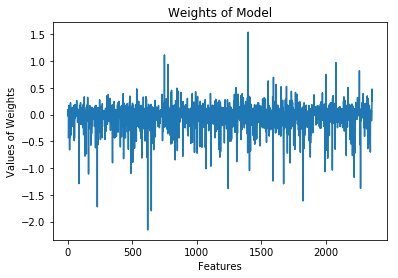

In [16]:
print('Coefficients: \n', cls.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test_kera, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_kera, y_pred))

plt.plot(cls.coef_)
plt.xlabel('Features')
plt.ylabel('Values of Weights')
plt.title('Weights of Model')
# Plot outputs
#plt.scatter(a[1:10400],y_pred,color='black')
#plt.scatter(X_train_onehot[:,0],y_test_kera,color='black')
#plt.plot(X_train_onehot[:,0], y_pred, color='blue')

#plt.xticks(())
#plt.yticks(())

plt.show()

In [17]:
from sklearn.linear_model import SGDClassifier
SGDClassifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGDClassifier.fit(X_train_onehot, y_train_kera)   

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
y_pred=SGDClassifier.predict(X_test_onehot)

In [19]:
SGDClassifier.coef_,SGDClassifier.intercept_

(array([[ 0.02806822,  0.09558538, -0.1382365 , ...,  0.1239285 ,
          0.13864491,  0.18719673]]), array([1.10605931]))

In [20]:
from sklearn import svm
svm = svm.SVR()
svm.fit(X_train_onehot, y_train_kera) 

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
y_pred=svm.predict(X_test_onehot)

In [22]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_kera, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.99



imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index



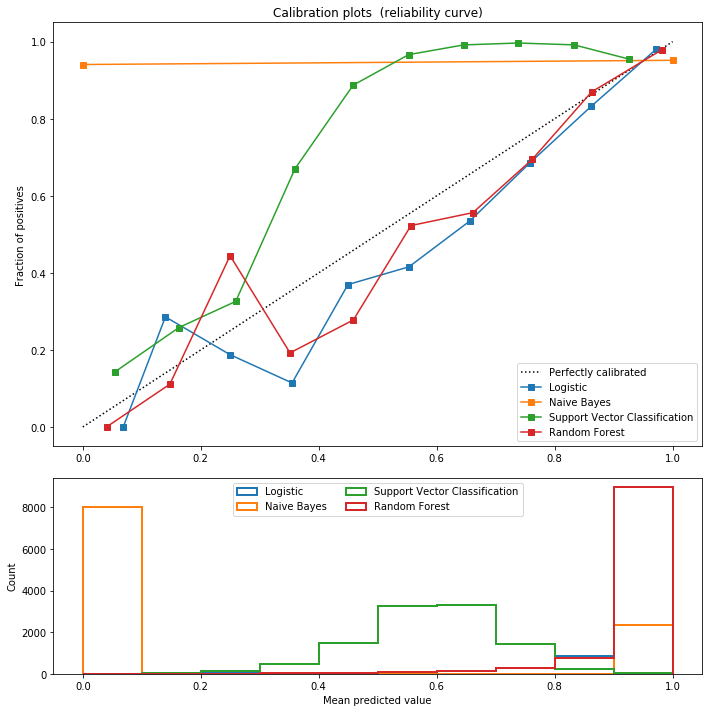

In [31]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train_onehot.toarray(), y_train_kera)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test_onehot.toarray())[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test_onehot.toarray())
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test_kera, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Ridge = Ridge()


coefs = []
errors = []

alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in alphas:
    Ridge.set_params(alpha=a)
    Ridge.fit(X_train_onehot, y_train_kera)
    coefs.append(Ridge.coef_)
    errors.append(mean_squared_error(Ridge.coef_,y_pred))

# Display results
plt.figure(figsize=(20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularization')
plt.axis('tight')

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2363, 10399]